In [1]:
import pickle
import multidms
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import numpy as np
import pandas as pd
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.lines as mlines

In [2]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [84]:
OUTDIR = "results/gamma/"
# title = "Shrinkage Analysis of $C_{d}$ Models, \nbarcodes NOT collapsed"
title = "Shrinkage Analysis of $\gamma$-corrected Models, \nbarcodes NOT collapsed"

In [85]:
# models = pickle.load(open("old-notebooks/gamma-noch-models.pkl", "rb"))
# models = pickle.load(open("old-notebooks/ch-nogamma-models.pkl", "rb"))
models = pickle.load(open(f"{OUTDIR}/models.pkl", "rb"))


In [86]:
models

,dataset,δ_huber,λ_lasso_shift,λ_ridge_beta,λ_ridge_shift,λ_ridge_gamma,data_idx,epistatic_model,output_activation,lock_beta,...,init_C_ref,warmup_beta,tol,num_training_steps,iterations_per_step,save_model_at,PRNGKey,step_loss,model_20000,replicate
0,<multidms.data.MultiDmsData object at 0x7fa380...,1,0.0,0,0,0.001,0,Sigmoid,Softplus,False,...,0.0,False,0.000001,20,1000,[20000],0,"[1.1543217024445156, 0.9895311531670269, 0.948...",<multidms.model.MultiDmsModel object at 0x7f9e...,0
1,<multidms.data.MultiDmsData object at 0x7fa02a...,1,0.0,0,0,0.001,0,Sigmoid,Softplus,False,...,0.0,False,0.000001,20,1000,[20000],0,"[1.1616443436982988, 0.9874196797398254, 0.944...",<multidms.model.MultiDmsModel object at 0x7fa0...,1
2,<multidms.data.MultiDmsData object at 0x7fa380...,1,0.000001,0,0,0.001,0,Sigmoid,Softplus,False,...,0.0,False,0.000001,20,1000,[20000],0,"[1.1583895510700528, 0.9919028532438301, 0.949...",<multidms.model.MultiDmsModel object at 0x7f9e...,0
3,<multidms.data.MultiDmsData object at 0x7fa02a...,1,0.000001,0,0,0.001,0,Sigmoid,Softplus,False,...,0.0,False,0.000001,20,1000,[20000],0,"[1.1613331222803986, 0.9879005653874817, 0.945...",<multidms.model.MultiDmsModel object at 0x7f9e...,1
4,<multidms.data.MultiDmsData object at 0x7fa380...,1,0.00001,0,0,0.001,0,Sigmoid,Softplus,False,...,0.0,False,0.000001,20,1000,[20000],0,"[1.174152254367906, 1.008211542371055, 0.95911...",<multidms.model.MultiDmsModel object at 0x7f9e...,0
5,<multidms.data.MultiDmsData object at 0x7fa02a...,1,0.00001,0,0,0.001,0,Sigmoid,Softplus,False,...,0.0,False,0.000001,20,1000,[20000],0,"[1.174258200927089, 1.0043018868498799, 0.9544...",<multidms.model.MultiDmsModel object at 0x7f9e...,1
6,<multidms.data.MultiDmsData object at 0x7fa380...,1,0.00002,0,0,0.001,0,Sigmoid,Softplus,False,...,0.0,False,0.000001,20,1000,[20000],0,"[1.1949222942020625, 1.0295647128284433, 0.980...",<multidms.model.MultiDmsModel object at 0x7f9e...,0
7,<multidms.data.MultiDmsData object at 0x7fa02a...,1,0.00002,0,0,0.001,0,Sigmoid,Softplus,False,...,0.0,False,0.000001,20,1000,[20000],0,"[1.1882154369736713, 1.0233002576908987, 0.972...",<multidms.model.MultiDmsModel object at 0x7f9e...,1
8,<multidms.data.MultiDmsData object at 0x7fa380...,1,0.00005,0,0,0.001,0,Sigmoid,Softplus,False,...,0.0,False,0.000001,20,1000,[20000],0,"[1.2373544499097635, 1.0750526750868692, 1.032...",<multidms.model.MultiDmsModel object at 0x7f9e...,0
9,<multidms.data.MultiDmsData object at 0x7fa02a...,1,0.00005,0,0,0.001,0,Sigmoid,Softplus,False,...,0.0,False,0.000001,20,1000,[20000],0,"[1.2355793784047775, 1.0685640367108826, 1.022...",<multidms.model.MultiDmsModel object at 0x7f9e...,1


In [87]:
lasso_cmap=plt.get_cmap("Set2").colors
lasso_shrinkage = sorted(models.λ_lasso_shift.unique())
lasso_shrinkage_cmap = dict(zip(lasso_shrinkage, lasso_cmap))
mutations_to_highlight = ["D142L", "A419S", "A570D", "K854N", "T1027I"]
mutations_cmap=plt.get_cmap("Accent").colors
mutations_cmap = dict(zip(mutations_to_highlight, mutations_cmap))
times_seen_threshold = 3

In [88]:
# plt.rcParams['axes.grid'] = False

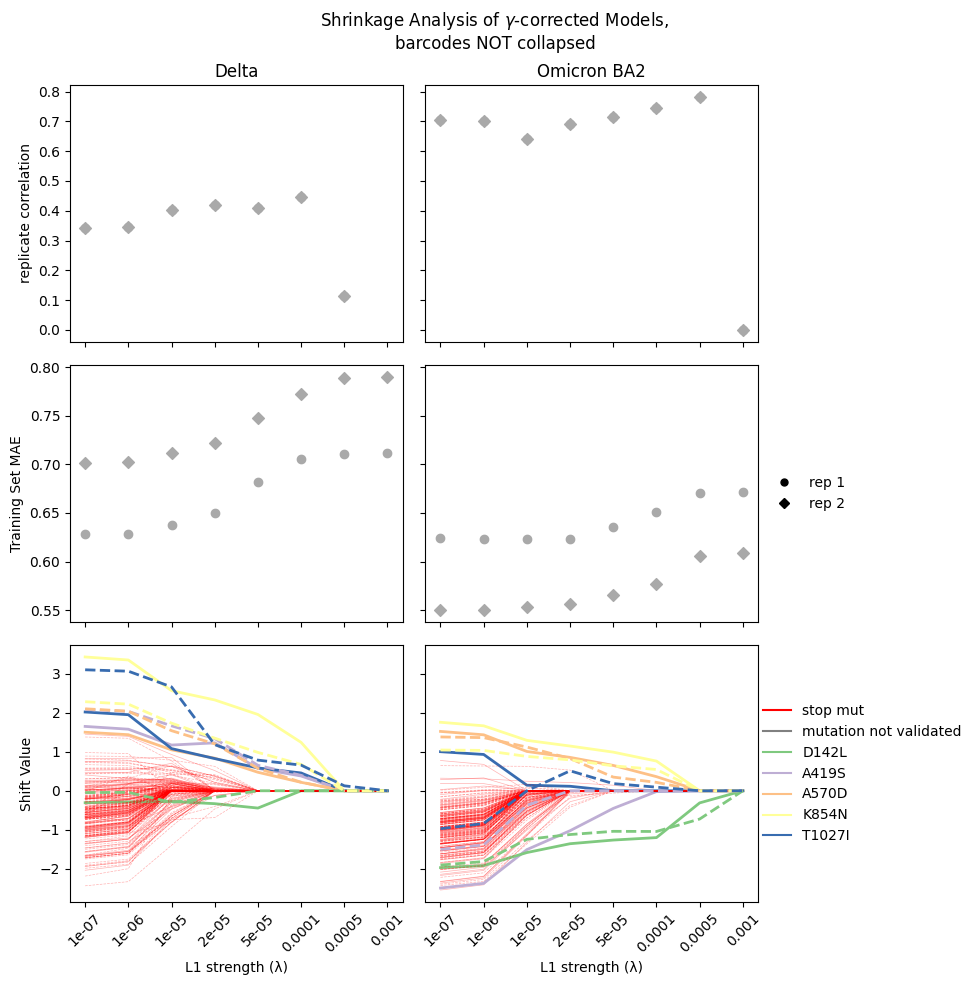

In [89]:
fig, ax = plt.subplots(3,2, figsize=[10,10],sharex=True, sharey='row')
# plt.rcParams['axes.grid'] = True

# t_points = np.linspace(0, 2.5, 100)
# def perc_abs_lte(x, t):
#     abs_x = np.abs(x)
#     return len(abs_x[abs_x<=t]) / len(x)

for lasso, lasso_replicates in models.groupby("λ_lasso_shift"):
    
    fit_dict = {}
    for _, row in lasso_replicates.iterrows():
        model = row.model_20000
        replicate = row.replicate
        fit_dict[f"{replicate}"] = model

    muts_df_outer = multidms.utils.combine_replicate_muts(
        fit_dict, 
        times_seen_threshold=times_seen_threshold, 
        how="outer"
    )
    muts_df_inner = muts_df_outer.dropna()
    
    # plot corr by sparsity
    for cond in model.data.conditions:
        if cond == model.data.reference: continue
        axes = ax[0, 0] if cond == "Delta" else ax[0, 1]
        if np.all(muts_df_inner[f"0_S_{cond}"] == 0) or np.all(muts_df_inner[f"1_S_{cond}"] == 0):
            continue
        corr = pearsonr(muts_df_inner[f"0_S_{cond}"], muts_df_inner[f"1_S_{cond}"])[0]
        
        
        for rep, marker in zip([0,1], ["o", "D"]):
            rep_cond_shifts = muts_df_outer[f"{rep}_S_{cond}"]
            sparsity = len(rep_cond_shifts[rep_cond_shifts==0]) / len(rep_cond_shifts)
#             axes.scatter(sparsity,corr, marker=marker, color=lasso_shrinkage_cmap[lasso])
#             axes.scatter(str(lasso),corr, marker=marker, color=lasso_shrinkage_cmap[lasso])
            axes.scatter(str(lasso),corr, marker=marker, color="darkgrey")
            
    # plot mae 
    for _, row in lasso_replicates.iterrows():
        model = row.model_20000
        replicate = row.replicate
        marker = "o" if replicate ==0 else "D"
        for cond in model.data.conditions:
            if cond == model.data.reference: continue
            axes = ax[1, 0] if cond == "Delta" else ax[1, 1]
            
#             rep_cond_shifts = model.mutations_df[f"S_{cond}"]
#             sparsity = len(rep_cond_shifts[rep_cond_shifts==0]) / len(rep_cond_shifts)
            
            vdf = model.variants_df.query("condition == @cond")
            mae = np.sum(np.abs(vdf.predicted_func_score - vdf.corrected_func_score))/len(vdf)
#             mae = np.sum(np.abs(vdf.predicted_func_score - vdf.corrected_func_score)**2)/len(vdf)
            
#             axes.scatter(sparsity,mae, marker=marker, color=lasso_shrinkage_cmap[lasso])
#             axes.scatter(str(lasso),mae, marker=marker, color=lasso_shrinkage_cmap[lasso])
            axes.scatter(str(lasso),mae, marker=marker, color="darkgrey")
            
            
#             break
#         break
#     break
            
            
#     plot percentage of shifts < t
#     for cond in model.data.conditions:
#         if cond == model.data.reference: continue
#         axes = ax[1, 0] if cond == "Delta" else ax[1, 1]
#         for rep, style in zip([0,1], ["-", "--"]):
#             rep_cond_shifts = muts_df_outer[f"{rep}_S_{cond}"]
#             lt_percentages = [perc_abs_lte(rep_cond_shifts, t) for t in t_points]
#             axes.plot(t_points, lt_percentages, color=lasso_shrinkage_cmap[lasso], linestyle=style)
    
            
ax[0,0].set_ylabel("replicate correlation")
# ax[0,0].set_xlabel("model sparsity (%S == 0)")
# ax[0,1].set_xlabel("model sparsity (%S == 0)")
ax[0, 0].set_title("Delta")
ax[0, 1].set_title("Omicron BA2")
# ax[1,0].set_ylabel("Fraction of Shift \nParameters with values <= x")
ax[1,0].set_ylabel("Training Set MAE")
# ax[1,0].set_xlabel("Shift Value")
# ax[1,1].set_xlabel("Shift Value")
# ax[0, 0].get_shared_y_axes().join(ax[0, 0], ax[0, 1])
# ax[2, 0].get_shared_y_axes().join(ax[2, 0], ax[2, 1])


# elbow plot legend
black_circle = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                          markersize=5, label='rep 1')
black_triangle = mlines.Line2D([], [], color='black', marker='D', linestyle='None',
                          markersize=5, label='rep 2')
# lasso_color_handles = [
#     mlines.Line2D(
#         [], [], 
#         color=color, 
#         linestyle='-',
#         markersize=10,
#         label=f"λ = {lasso}"
#     )
#     for lasso, color in lasso_shrinkage_cmap.items()
# ]
elements = [black_circle, black_triangle] #+lasso_color_handles
ax[1, 1].legend(handles=elements, bbox_to_anchor = (1.30, 0.5), loc='center right', frameon=False)

# # percent under x legend
# black_line = mlines.Line2D([], [], color='black', linestyle='-',
#                           markersize=5, label='rep 1')
# black_dashed = mlines.Line2D([], [], color='black',linestyle='--',
#                           markersize=5, label='rep 2')
# elements = [black_line, black_dashed]
# ax[1, 1].legend(handles=elements, bbox_to_anchor = (1.35, 0.5), loc='center right', frameon=False)


for replicate, rep_models in models.groupby("replicate"):
    fit_dict = {row.λ_lasso_shift:row.model_20000 for _, row in rep_models.iterrows()}
    mut_df = multidms.utils.combine_replicate_muts(
        fit_dict, 
        times_seen_threshold=times_seen_threshold, 
        how="outer"
    )

    mut_df = pd.melt(
        mut_df.reset_index(), 
        id_vars=["mutation"],
        value_vars=[
            col for col in mut_df.columns 
            if "_S_" in col and "avg" not in col
        ],
        value_name="S"
    )
    mut_df = mut_df.assign(
        λ_lasso=[ 
            v.split("_")[0]
            for v in mut_df.variable
        ],
        is_stop=[
            True if "*" in mut else False
            for mut in mut_df.mutation
        ],
        condition=[
            "_".join(v.split("_")[2:])
            for v in mut_df.variable
        ]
    )
    
    mut_df.drop("variable", axis=1, inplace=True)
    for condition, condition_muts in mut_df.groupby("condition"):
        axes = ax[2,0] if condition == "Delta" else ax[2,1]
        color, alpha, width ="grey", 0.01, 0.5
        style = "-" if replicate == 0 else "--"
        
        # plot background traces
#         for mut, trace_df in condition_muts.query(
#             "not is_stop & not mutation.isin(@mutations_to_highlight)"
#         ).groupby("mutation"):
            
#             axes.plot(
#                 trace_df.λ_lasso, 
#                 trace_df.S,
#                 linestyle=style,
#                 linewidth=width,
#                 alpha=alpha,
#                 color=color
#             )
        
        # plot stop traces
        for mut, trace_df in condition_muts.query("is_stop").groupby("mutation"):
            color, alpha="red", 0.3
            axes.plot(
                trace_df.λ_lasso, 
                trace_df.S,
                linestyle=style,
                linewidth=width,
                alpha=alpha,
                color=color
            )
            
        # plot highlighted muts
        for mut, trace_df in condition_muts.query(
            "mutation.isin(@mutations_to_highlight)"
        ).groupby("mutation"):
            color, alpha, width = mutations_cmap[mut], 1.0, 2.0
            axes.plot(
                trace_df.λ_lasso, 
                trace_df.S,
                linestyle=style,
                linewidth=width,
                alpha=alpha,
                color=color
            )

ax[2,0].set_xticks(ax[2,0].get_xticks(), ax[2,0].get_xticklabels(), rotation=45, ha='center')
ax[2,1].set_xticks(ax[2,1].get_xticks(), ax[2,1].get_xticklabels(), rotation=45, ha='center')
ax[2,0].set_ylabel("Shift Value")
ax[2,0].set_xlabel("L1 strength (λ)")
ax[2,1].set_xlabel("L1 strength (λ)")

red_line = mlines.Line2D([], [], color='red', linestyle='-',
                          markersize=1, label='stop mut')
grey_line = mlines.Line2D([], [], color='grey',  linestyle='-',
                          markersize=5, label='mutation not validated')
mutation_color_handles = [
    mlines.Line2D(
        [], [], 
        color=color, 
        linestyle='-',
        markersize=10,
        label=f"{mutation}"
    )
    for mutation, color in mutations_cmap.items()
]
elements = [red_line, grey_line]+mutation_color_handles
ax[2, 1].legend(handles=elements, bbox_to_anchor = (1.65, 0.5), loc='center right', frameon=False)


fig.suptitle(title)
plt.tight_layout()
fig.savefig(f"{OUTDIR}/models-summary.pdf")
plt.show()

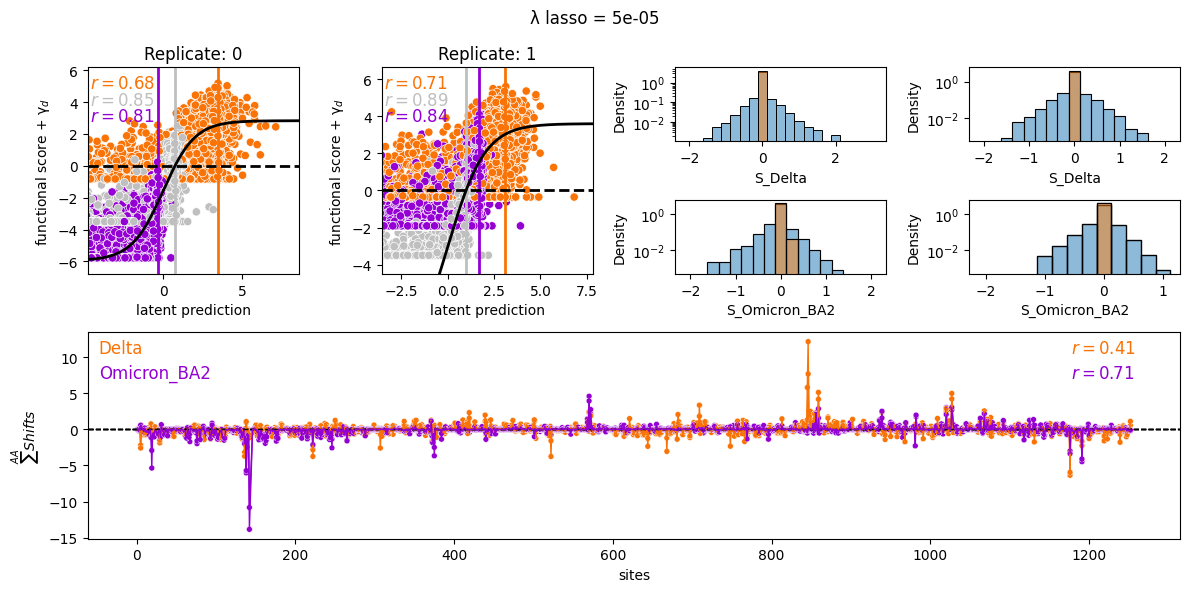

In [90]:
hist_ax_map = {
    "Delta-0" : "A",
    "Delta-1" : "B",
    "Omicron_BA2-0" : "C",
    "Omicron_BA2-1" : "D"
}

for i, (lasso, lasso_replicates) in enumerate(models.groupby("λ_lasso_shift")):
    if lasso != 5e-5: continue
    i=0
    fig, ax = plt.subplot_mosaic(
        """
        01AB
        01CD
        SSSS
        SSSS
        """,
        figsize=[12,6]
    )
#     ax[f"S"].set_ylim([-20, 20])
    
    fit_dict = {}
    for _, row in lasso_replicates.iterrows():
        replicate = row.replicate
        model = row.model_20000
        fit_dict[f"{replicate}"] = model
        
        # epistasis and accuracy
        model.plot_epistasis(show=False, ax=ax[str(replicate)], sample=0.1, legend=False)
        ax[str(replicate)].set_xlabel("latent prediction")
        ax[str(replicate)].set_title(f"Replicate: {replicate}")
        var_df = model.variants_df
        
        for b, cond in enumerate(model.data.conditions):
            var_df_cond = var_df.query(f"condition == @cond")
            corr = pearsonr(
                var_df_cond["predicted_func_score"], 
                var_df_cond["corrected_func_score"] 
            )[0]
            ax[str(replicate)].annotate(
                f"$r = {corr:.2f}$", 
                (0.01, (0.90 - (b*0.08))), 
                xycoords="axes fraction", 
                fontsize=12,
                c = model.data.condition_colors[cond]
            )
            
            if cond == model.data.reference: continue
            model.plot_shifts_by_site(
                cond, 
                show=False, 
                agg_func=np.sum, 
                times_seen_threshold=3, 
                ax=ax[f"S"], 
                lw=1
            )
    muts_df_outer = multidms.utils.combine_replicate_muts(fit_dict, times_seen_threshold=3, how="outer")
    muts_df_inner = muts_df_outer.dropna()
    for b, cond in enumerate(model.data.conditions):
        if cond == model.data.reference: continue 
        corr = pearsonr(muts_df_inner[f"0_S_{cond}"], muts_df_inner[f"1_S_{cond}"])[0]
        ax[f"S"].annotate(
            f"$r = {corr:.2f}$", 
            (0.9, (0.9 - (b*0.06))), 
            xycoords="axes fraction", 
            fontsize=12,
            c = model.data.condition_colors[cond]
        )
        
        ax[f"S"].annotate(
            cond, 
            (0.01, (0.90 - (b*0.06))), 
            xycoords="axes fraction", 
            fontsize=12,
            c = model.data.condition_colors[cond]
        )
        
    ax[f"S"].set_ylabel("$\sum^{AA} Shifts$")
    
    for _, row in lasso_replicates.iterrows():
        replicate = row.replicate
        model = row.model_20000
        for b, cond in enumerate(model.data.conditions):
            if cond == model.data.reference: continue   
            axes = ax[hist_ax_map[f"{cond}-{replicate}"]]
            model.plot_param_hist(f"S_{cond}",show=False, ax=axes)
            axes.set_yscale("log")
        
    
#     muts_df_outer = muts_df_outer[
#         [c for c in muts_df_outer.columns if "S_" in c and "avg" not in c]
#     ]
#     muts_df_outer.rename(
#         {
#             "0_S_Omicron_BA2":"BA2 (1)", 
#             "1_S_Omicron_BA2":"BA2 (2)",
#             "0_S_Delta":"Delta (1)",
#             "1_S_Delta":"Delta (2)"
#         },
#         axis=1,
#         inplace=True
#     )
#     muts_df_outer = muts_df_outer.assign(
#         is_stop=[
#             "stop" if "*" in m else "non-stop" 
#             for m in muts_df_outer.index.values
#         ]
#     )
#     melted_mut_df = pd.melt(muts_df_outer.reset_index(), id_vars=["mutation", "is_stop"])
#     sns.violinplot(
#         melted_mut_df, 
#         x="variable", 
#         y="value", 
#         hue="is_stop", 
#         ax = ax[f"D"],
#         split=True
#     )

#     ax[f"D"].legend(bbox_to_anchor=(1.00, 1), borderaxespad=0, frameon=False)

        
#     for os, (cond, cond_df) in enumerate(melted_mut_df.groupby("variable")):
#         exact_sparsity = len(cond_df[cond_df['value'] == 0]) / len(cond_df)
# #         close_sparsity = len(cond_df[onp.isclose(cond_df['value'], 0)]) / len(cond_df)
        
#         ax[f"D"].annotate(f"==0    : {round(exact_sparsity, 3)}", (os-0.3, -4))
# #         ax[f"D"].annotate(f"<=1e-8 : {round(close_sparsity, 3)}", (os-0.3, -4.7))
        
    
#     ax["D"].legend(bbox_to_anchor=(1.00, 1), borderaxespad=0, frameon=False)
    
    fig.suptitle(f"λ lasso = {lasso}")
    plt.tight_layout()
#     fig.savefig(f"ch-nogamma-summary-{lasso}.pdf")
    fig.savefig(f"{OUTDIR}/lasso_5e-5.pdf")
    
    plt.show()